In [1]:
# TESTING WITH LATEST DATASET (08:00, 28, Friday, December, 2025) -> (22:00, 30, Sunday, December, 2025)

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

PROM_URL = "http://10.35.29.108:30900/api/v1/query_range"

# Worker-only CPU usage (10.35.29.109 and 10.35.29.110) (Only Worker Node)
CPU_QUERY = r'''(sum(rate(node_cpu_seconds_total{mode!="idle", instance=~"10\\.35\\.29\\.(109|110):9100"}[1m])) /
sum(rate(node_cpu_seconds_total{instance=~"10\\.35\\.29\\.(109|110):9100"}[1m]))) * 100'''

# Pending pods
PENDING_QUERY = r'''sum(kube_pod_status_phase{phase="Pending"})'''

# TIME RANGE (THAILAND UTC+7)
TH = timezone(timedelta(hours=7))
start = datetime(2025, 11, 28, 8, 0, 0, tzinfo=TH)
end   = datetime(2025, 11, 30, 22, 0, 0, tzinfo=TH)
start_ts = start.timestamp() # converted automatically to UTC for Prometheus
end_ts   = end.timestamp()

print("Querying between:")
print("Local TH start:", start)
print("Local TH end:  ", end)
print("Unix start:", start_ts)
print("Unix end:  ", end_ts)

def query_prometheus(promql):
    params = {
        "query": promql,
        "start": start_ts,
        "end": end_ts,
        "step": "60s"
    }
    response = requests.get(PROM_URL, params=params).json()

    if len(response["data"]["result"]) == 0:
        print("⚠️ No data returned for query:", promql)
        return []

    return response["data"]["result"][0]["values"]

cpu_data = query_prometheus(CPU_QUERY)
pending_data = query_prometheus(PENDING_QUERY)

df_cpu = pd.DataFrame(cpu_data, columns=["timestamp", "cpu"])
df_cpu["timestamp"] = pd.to_datetime(df_cpu["timestamp"], unit="s", utc=True).dt.tz_convert("Asia/Bangkok")
df_cpu["cpu"] = df_cpu["cpu"].astype(float)

df_pending = pd.DataFrame(pending_data, columns=["timestamp", "pending"])
df_pending["timestamp"] = pd.to_datetime(df_pending["timestamp"], unit="s", utc=True).dt.tz_convert("Asia/Bangkok")
df_pending["pending"] = df_pending["pending"].astype(float)

df = pd.merge(df_cpu, df_pending, on="timestamp", how="inner")

df.to_csv("CPU_Usage_&_Pending_Pod_Dateset.csv", index=False)
print("Saved as CPU_Usage_&_Pending_Pod_Dateset.csv")

df.head()

Querying between:
Local TH start: 2025-11-28 08:00:00+07:00
Local TH end:   2025-11-30 22:00:00+07:00
Unix start: 1764291600.0
Unix end:   1764514800.0
Saved as CPU_Usage_&_Pending_Pod_Dateset.csv


,timestamp,cpu,pending
0,2025-11-28 08:00:00+07:00,54.042962,1.0
1,2025-11-28 08:01:00+07:00,54.201317,1.0
2,2025-11-28 08:02:00+07:00,54.644381,1.0
3,2025-11-28 08:03:00+07:00,54.483660,1.0
4,2025-11-28 08:04:00+07:00,54.883033,1.0


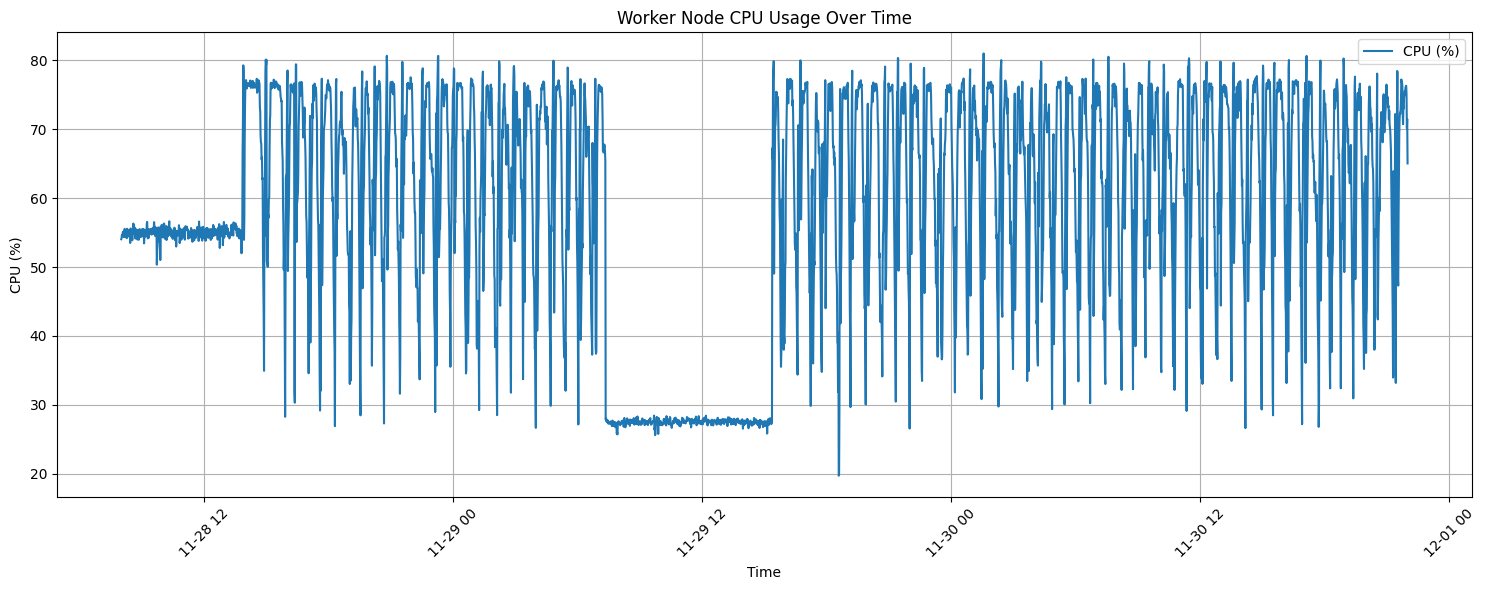

<Figure size 640x480 with 0 Axes>

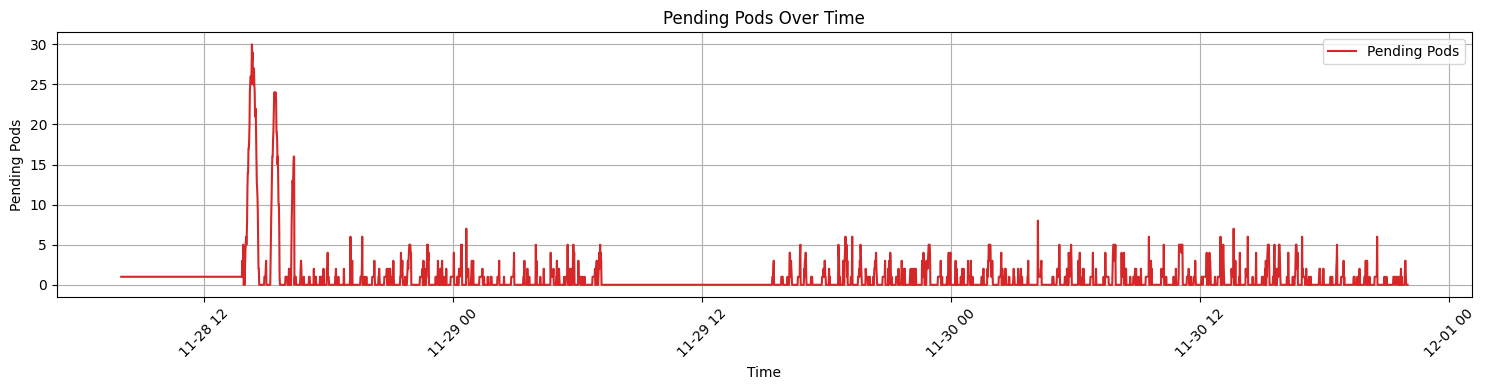

<Figure size 640x480 with 0 Axes>

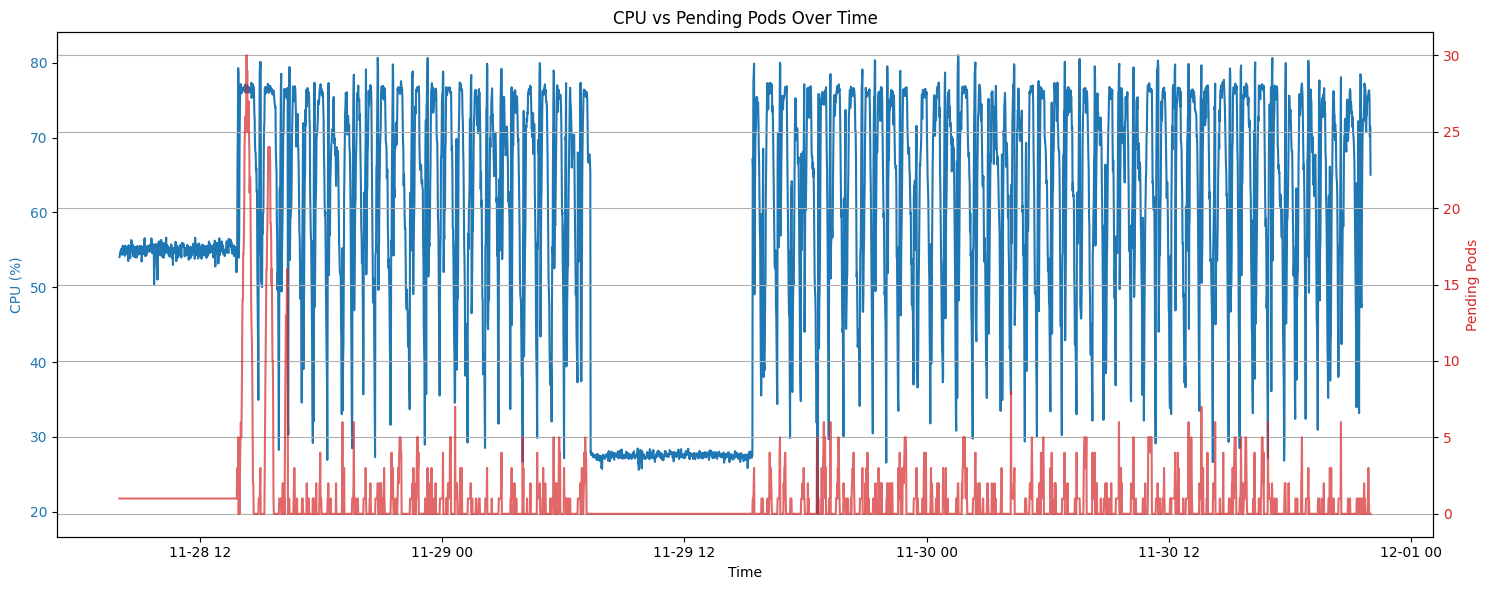

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("CPU_Usage_&_Pending_Pod_Dateset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")


# PLOT CPU USAGE
plt.figure(figsize=(15, 6))
plt.plot(df["timestamp"], df["cpu"], label="CPU (%)", color="tab:blue")
plt.title("Worker Node CPU Usage Over Time")
plt.xlabel("Time")
plt.ylabel("CPU (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("CPU_Plot.png", dpi=300)


# PLOT PENDING PODS
plt.figure(figsize=(15, 4))
plt.plot(df["timestamp"], df["pending"], label="Pending Pods", color="tab:red")
plt.title("Pending Pods Over Time")
plt.xlabel("Time")
plt.ylabel("Pending Pods")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("Pending_Pod_Plot.png", dpi=300)


# COMBINED VIEW (CPU + Pending)
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(df["timestamp"], df["cpu"], color="tab:blue", label="CPU (%)")
ax1.set_xlabel("Time")
ax1.set_ylabel("CPU (%)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df["timestamp"], df["pending"], color="tab:red", label="Pending Pods", alpha=0.7)
ax2.set_ylabel("Pending Pods", color="tab:red")
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title("CPU vs Pending Pods Over Time")
plt.xticks(rotation=45)
plt.grid(True)
fig.tight_layout()
plt.show()
# plt.savefig("CPU_&_Pending_Pod_Combined.png", dpi=300)

2025-12-01 17:58:54.852294: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 17:58:56.125513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 17:58:58.364439: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


X shape: (3696, 20, 2)
y shape: (3696,)
Train samples: 2956
Test samples: 740


2025-12-01 17:58:59.125696: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/testuser/CPE-SENIOR-PROJECT-K8S/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0781 - mae: 0.2127 - val_loss: 0.0572 - val_mae: 0.2048
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0410 - mae: 0.1596 - val_loss: 0.0524 - val_mae: 0.1947
Epoch 3/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0358 - mae: 0.1456 - val_loss: 0.0449 - val_mae: 0.1813
Epoch 4/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0302 - mae: 0.1303 - val_loss: 0.0378 - val_mae: 0.1612
Epoch 5/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0296 - mae: 0.1283 - val_loss: 0.0345 - val_mae: 0.1458
Epoch 6/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0299 - mae: 0.1297 - val_loss: 0.0343 - val_mae: 0.1496
Epoch 7/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0283 - mae: 0.1253 - val_loss: 0.0283 - val_mae: 0.1367
Epoch 8/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0281 - mae: 0.1259 - val_loss: 0.0333 - val_mae: 0.1439
Epoch 9/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0274 - mae: 

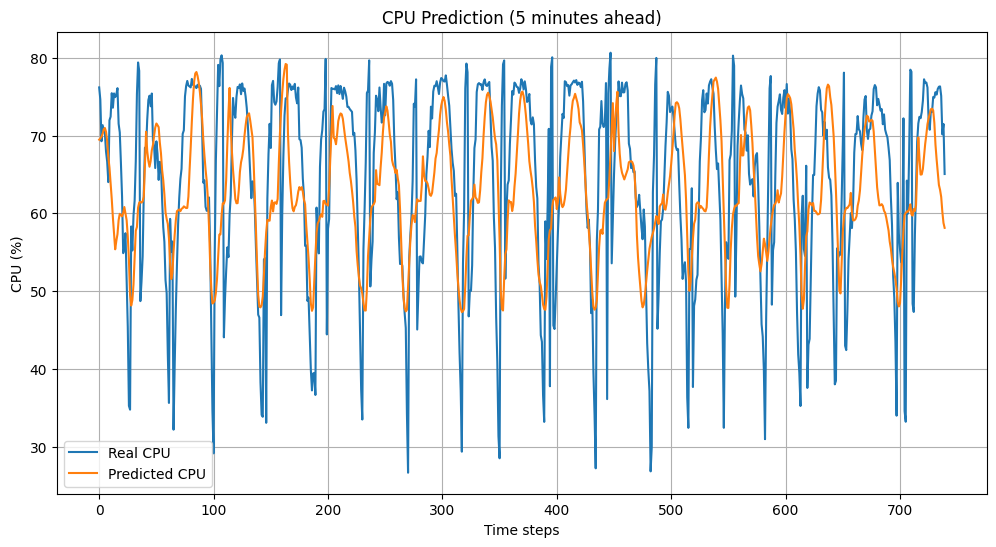

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

df = pd.read_csv("CPU_Usage_&_Pending_Pod_Dateset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# select features
data = df[["cpu", "pending"]].values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

SEQ_LEN = 20 # last 20 minutes as input
PRED_AHEAD = 5 # predict 5 minutes into future

X, y = [], []

for i in range(len(data_scaled) - SEQ_LEN - PRED_AHEAD):
    X.append(data_scaled[i:i+SEQ_LEN])
    y.append(data_scaled[i+SEQ_LEN+PRED_AHEAD][0])  # predict ONLY CPU

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)    # (samples, 20, 2)
print("y shape:", y.shape)    # (samples,)

# 80% first chunk → train
# 20% last chunk → test
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(SEQ_LEN, 2)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


y_pred = model.predict(X_test)

# invert normalization for BOTH test and predicted values
cpu_min, cpu_max = scaler.data_min_[0], scaler.data_max_[0]

y_test_real = y_test * (cpu_max - cpu_min) + cpu_min
y_pred_real = y_pred[:, 0] * (cpu_max - cpu_min) + cpu_min


plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Real CPU")
plt.plot(y_pred_real, label="Predicted CPU")
plt.title("CPU Prediction (5 minutes ahead)")
plt.xlabel("Time steps")
plt.ylabel("CPU (%)")
plt.legend()
plt.grid(True)
plt.show()